# Classify gestures by reading muscle activity

# 실험 요약

# 선정한 데이터 설명 및 데이터 출처

사람이 근육을 사용하여 몸을 움직일 때는 근전도(EMG)라는 것이 발생한다. 근전도는 근육에 있는 신경섬유에서 나오는 전기적 신호들이 합쳐져 발생하며, 이를 통해 근육의 상태나 행동 특징에 대해 파악할 수 있다. 최근의 연구 결과를 살펴보면, 일반적인 근육의 상태나 움직임을 파악할 수 있는 것뿐만 아니라 근육 관련 질환, 나아가 파킨슨병까지 진단할 수 있다고 한다. 최근에는 MYO라는 간편한 휴대용 근전도 기록 기기가 나와 보다 간편하게 application을 만들 수 있게 되었다. 

이번 기말과제에서 선정한 데이터는 Kaggle에 공개된 데이터셋, 'Classify gestures by reading muscle activity: a recording of human hand muscle activity producing four different hand gestures' (https://www.kaggle.com/kyr7plus/emg-4/home) 다. 데이터 자체가 흥미로울 뿐만 아니라 추후 다양한 어플리케이션, 특히 헬스케어 등 다양한 분야로 확장할 수 있다는 점이 매력적으로 느껴져 기말과제 주제로 선정하였다. 또한 공간적, 시간적으로 의미가 있는 데이터인 것 같아 기존의 머신러닝 모델뿐만 아니라 해당 특징을 가진 데이터에 효과적인 딥러닝 모델을 적용할 때 성능이 어떻게 나올지 궁금하기도 했다.

이 데이터셋은 MYO라는 근전도 기록 기기로 4가지의 손동작(가위, 바위, 보, ok)을 기록한 데이터들로 이루어져 있다. 8개의 센서가 8개의 연속된 시점으로 기록되어, 하나의 instance당 64개의 feature를 가지고 있다. 각 class당 약 2900개 내외의 데이터를 가지고 있어 총 11,678개의 instance가 데이터셋으로 공개되었다. 각 데이터는 200 Hz로 기록되었는데 이는 40ms의 단위로 기록되었음을 의미한다.

데이터 형식은 아래와 같이 주어진다.

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]

그리고 gesture class는 rock - 0, scissors - 1, paper - 2, ok - 3로 주어진다.

따라서 이 기말과제의 목적은 EMG 데이터를 활용하여 손동작 클래스를 구분하는 Classification 문제를 푸는 것이다.

# 실험 설계 및 방법

    • 자신이 선정한 모델 및 모델 선정에 대한 이유
    • 분석에 시도한 trial 및 error 에 대한 설명(초기 모델에서 기대 이하의 성능이 나올 경우, 모델의 설정에 다양한 변화를 주고 validation 을 통해 개선되는 점을 보여줄 것)
    • Data set 을 train-set, validation-set, test-set 으로 구분하여 사용하며, 최종 모델 평가는 test-set 을 통해 평가
    • 실험 설계 및 평가 분석에 overfitting 의 관점이 사용되어야 함.

## 라이브러리 불러오기 

In [1]:
# 라이브러리에서 가끔 발생하는 warning 무시 (보고서 가독성에 안 좋아서)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 전처리, 자료형, 시각화 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 머신러닝 모델 라이브러리
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

## 데이터 불러오기 

In [6]:
# load csv files by class
data_rock = pd.read_csv('./emg-4/0.csv',header=None)
data_scissors = pd.read_csv('./emg-4/1.csv',header=None)
data_paper = pd.read_csv('./emg-4/2.csv',header=None)
data_ok = pd.read_csv('./emg-4/3.csv',header=None)

In [7]:
data = pd.concat([data_rock,data_scissors,data_paper,data_ok],axis=0,ignore_index=True) # 데이터 통합하기

## 데이터 탐색 

데이터의 특징을 간단하게 알아보고 및 preprocessing을 진행하기 위해, 데이터 탐색을 진행한다.

### data.info() 

data.info() 함수를 통해 각 column의 데이터 개수, null 여부, 자료형을 확인한다.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 65 columns):
0     11678 non-null float64
1     11678 non-null float64
2     11678 non-null float64
3     11678 non-null float64
4     11678 non-null float64
5     11678 non-null float64
6     11678 non-null float64
7     11678 non-null float64
8     11678 non-null float64
9     11678 non-null float64
10    11678 non-null float64
11    11678 non-null float64
12    11678 non-null float64
13    11678 non-null float64
14    11678 non-null float64
15    11678 non-null float64
16    11678 non-null float64
17    11678 non-null float64
18    11678 non-null float64
19    11678 non-null float64
20    11678 non-null float64
21    11678 non-null float64
22    11678 non-null float64
23    11678 non-null float64
24    11678 non-null float64
25    11678 non-null float64
26    11678 non-null float64
27    11678 non-null float64
28    11678 non-null float64
29    11678 non-null float64
30    11678 non-null 

### data.describe() 

data.describe() 함수를 통해 데이터의 평균, 표준편차, 최소/최대값, 4분위값을 알아본다.

In [9]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


### Histogram 그리기 

64개의 feature의 분포에 대해 Label별로 색깔을 정해(파랑-바위, 주황-가위, 초록-보, 빨강-ok) Histogram을 그려 시각화.

8x8 배열에서 row는 8개의 연속된 시점, column은 8개의 sensor로 생각하면 된다.

대부분 정규분포를 따르고 있는 것으로 보이며, outlier는 크게 보이지 않는다.

다만 7번째 sensor에서 바위 class의 deviation이 큰 것으로 관찰되어, 이 부분은 rule-based로 잘 구분할 수 있을 것으로 예상된다.

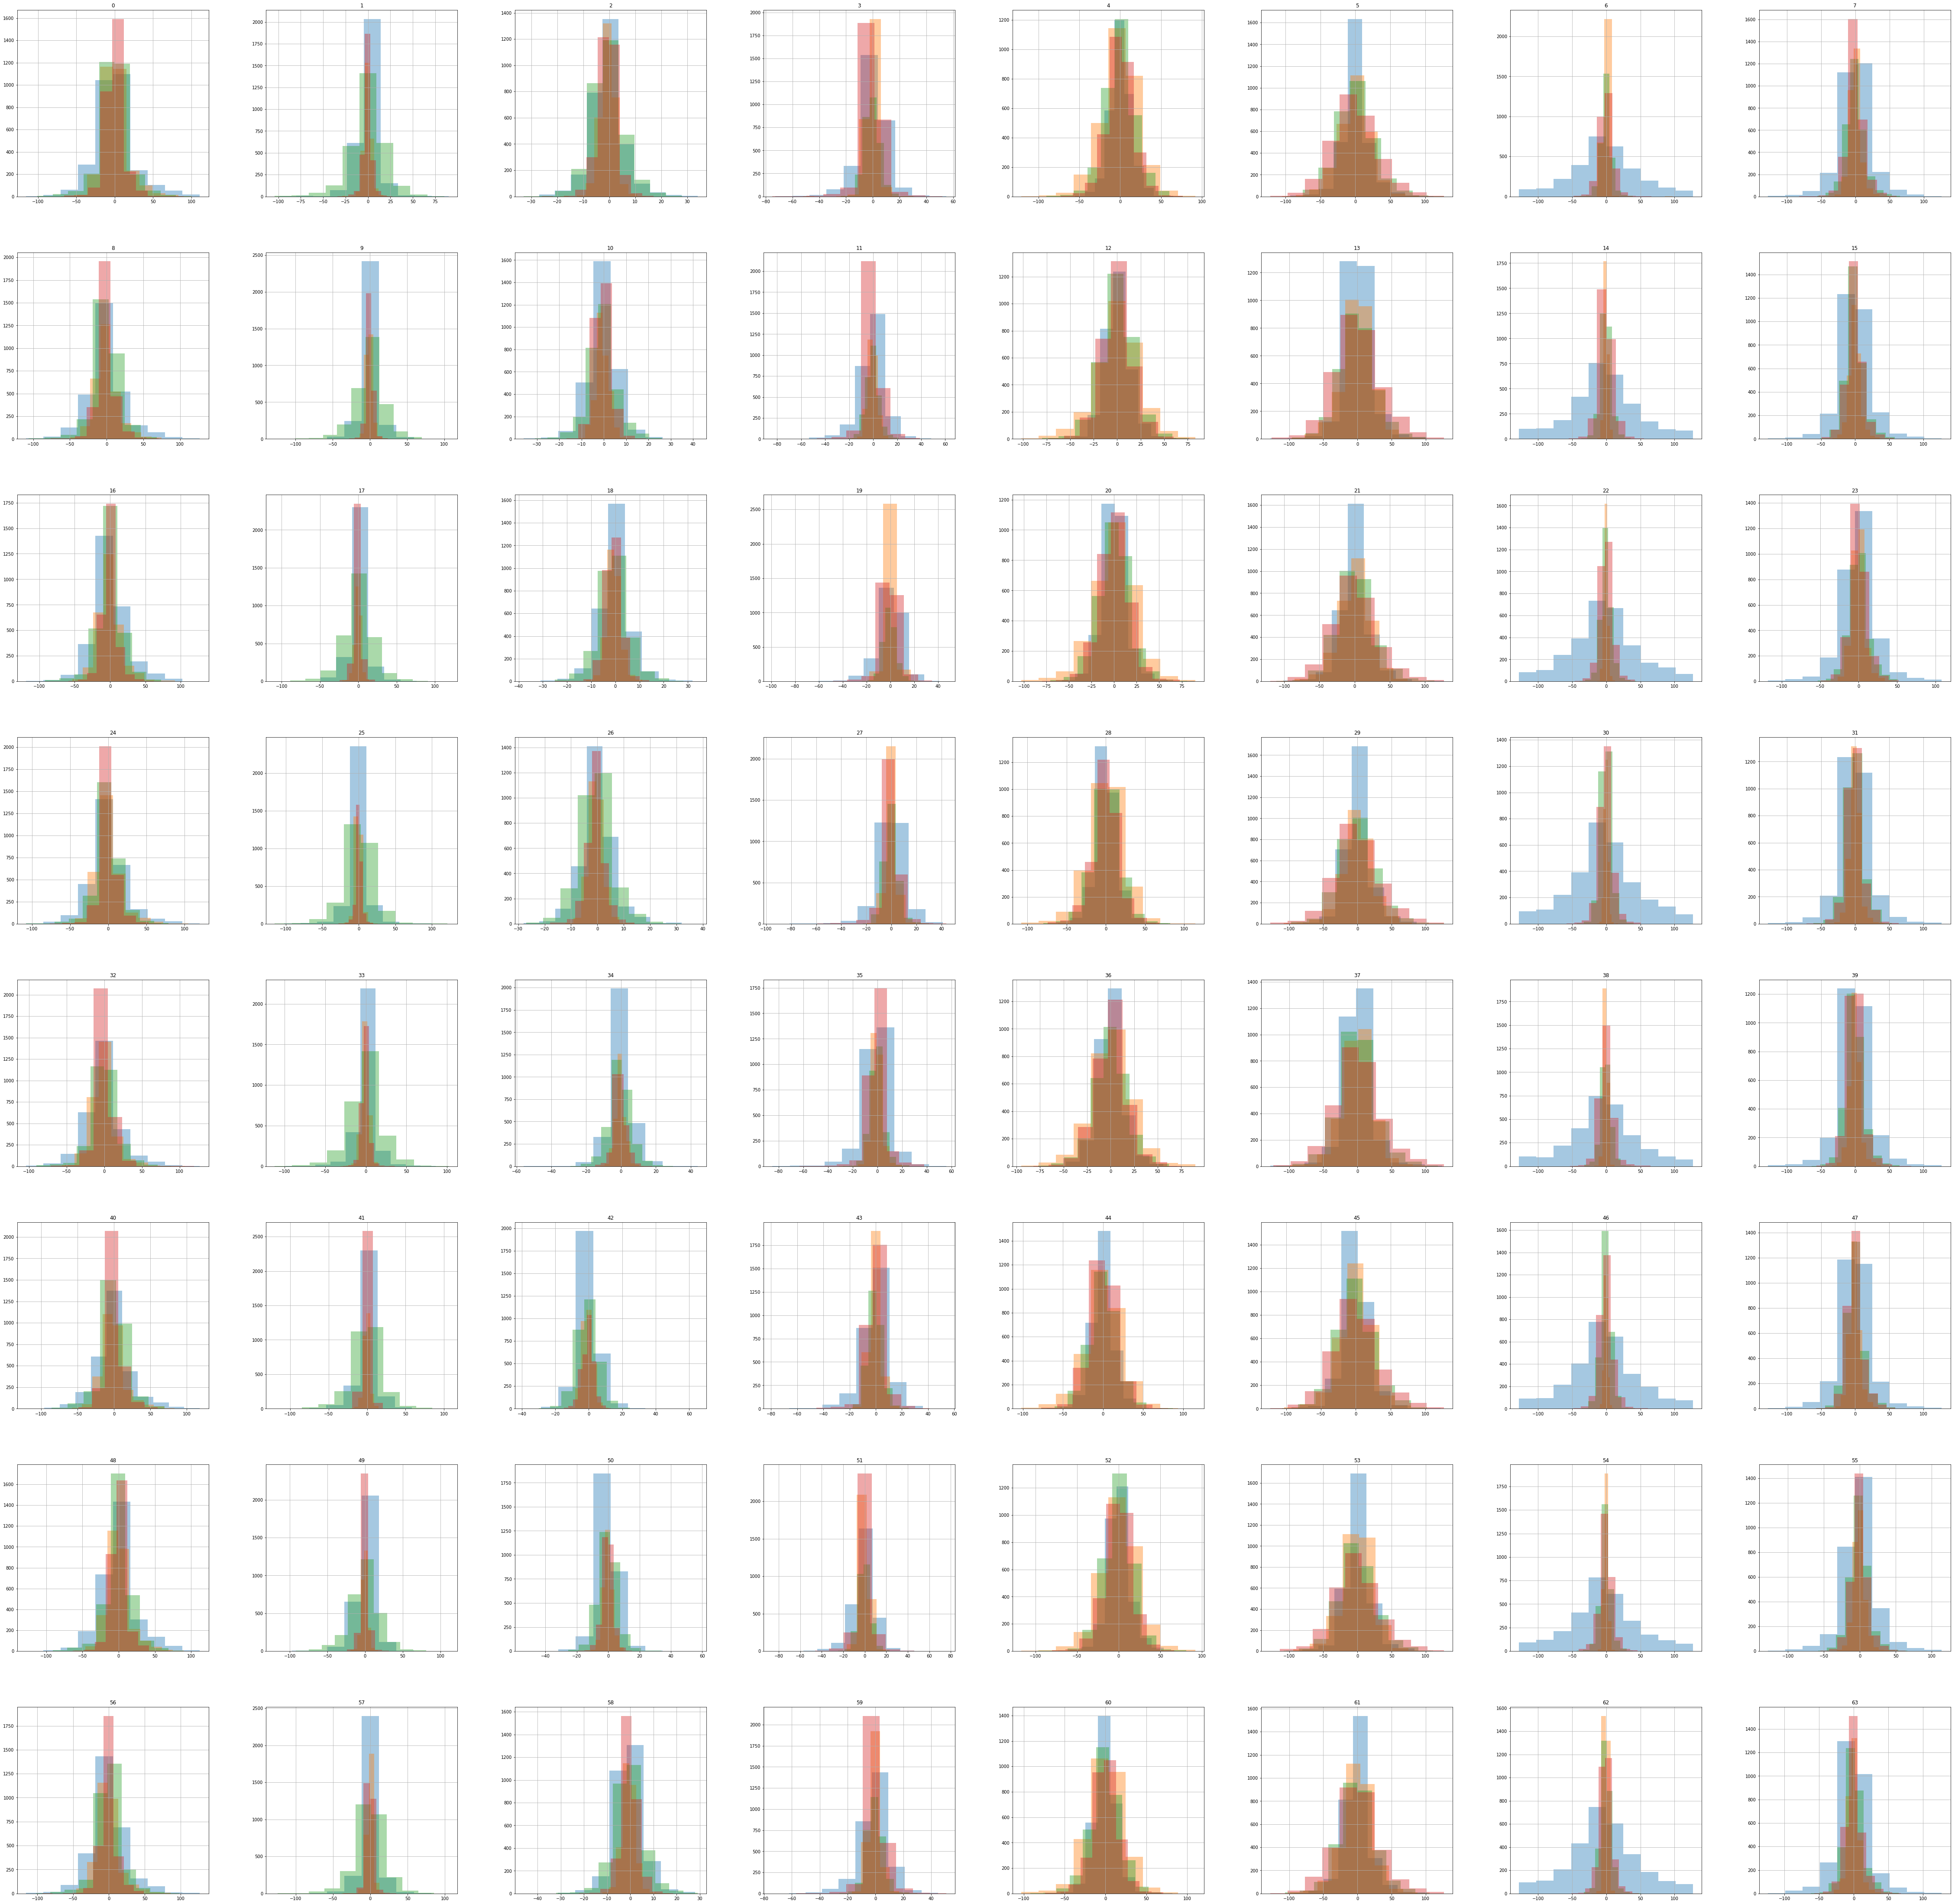

In [10]:
fig, axes = plt.subplots(8,8,figsize=(80,80))
for i in range(0,8):
    for j in range(0,8):
        data[[i*8+j,64]].groupby(64).hist(alpha=0.4,ax=axes[i][j])

plt.show()

## 데이터 train / test / validation 나누기 

60:20:20의 비율로 train / test / validation set을 나누었다.

In [11]:
X_train, X_, y_train, y_ = train_test_split(data.iloc[:,:64], data[64], test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [12]:
X_train.shape

(7006, 64)

In [13]:
X_test.shape

(2336, 64)

In [14]:
X_val.shape

(2336, 64)

In [15]:
y_train.shape

(7006,)

In [16]:
y_test.shape

(2336,)

In [17]:
y_val.shape

(2336,)

# 실험: 모델 적용 

## Baseline

Baseline model로 `sklearn`의 `DummyClassifier`를 활용하였다. 

현재 클래스 분포가 25:25:25:25로 균등하기 때문에 이와 비슷한 0.25 정도로 정확도가 나오고 있다.

In [18]:
baseline_stratified = DummyClassifier("stratified")
baseline_most_frequent = DummyClassifier("most_frequent")
baseline_uniform = DummyClassifier("uniform")

In [19]:
baseline_stratified.fit(X_train,y_train)
baseline_most_frequent.fit(X_train,y_train)
baseline_uniform.fit(X_train,y_train)
print("baseline - stratified acc:",baseline_stratified.score(X_val,y_val))
print("baseline - most frequent acc:",baseline_most_frequent.score(X_val,y_val))
print("baseline - uniform acc:",baseline_uniform.score(X_val,y_val))

baseline - stratified acc: 0.2542808219178082
baseline - most frequent acc: 0.2512842465753425
baseline - uniform acc: 0.24743150684931506


## Logistic Regression

가장 기본적인 Classifier인 Logistic regression부터 시작해보았다. 데이터에 non-linear한 feature가 많은 것인지 hyperparameter를 tuning하지 않은 첫번째 시도에서는 34.8%로 낮은 정확도를 보였다. 

train set과 validation set의 정확도를 비교해보니, 둘 다 비슷하게 낮은 것을 관찰할 수 있었다. 성능이 낮은 이유는 overfitting 때문이라기보다는 이 데이터셋에 있어서 linear model 자체가 가지는 한계점으로 보인다. 

`sklearn` 내부 라이브러리의 Logistic Regression이 가진 hyperparameter인 `solver`와 `multi_class`로 tuning을 시도하였으나 그다지 성능 향상이 크지 않았다. 

In [20]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,y_train)
print("Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
print("Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082


In [37]:
warnings.filterwarnings('ignore')
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solver in solver_list:
    lr_classifier = LogisticRegression(solver=solver)
    lr_classifier.fit(X_train,y_train)
    print("===== Solver:",solver,"=====")
    print("Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
    print("Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

===== Solver: newton-cg =====
Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082
===== Solver: lbfgs =====
Logistic Regression train acc: 0.38024550385383954
Logistic Regression val acc: 0.348458904109589
===== Solver: liblinear =====
Logistic Regression train acc: 0.38067370825007135
Logistic Regression val acc: 0.3480308219178082
===== Solver: sag =====
Logistic Regression train acc: 0.3781044818726806
Logistic Regression val acc: 0.3407534246575342
===== Solver: saga =====
Logistic Regression train acc: 0.37582072509277764
Logistic Regression val acc: 0.336472602739726


In [22]:
multiclass_list = ['ovr', 'multinomial']
for multiclass in multiclass_list:
    lr_classifier = LogisticRegression(solver='lbfgs',multi_class=multiclass)
    lr_classifier.fit(X_train,y_train)
    print("===== multi_class:",multiclass,"=====")
    print("Multiclass-",multiclass,"Logistic Regression train acc:",lr_classifier.score(X_train,y_train))
    print("Multiclass-",multiclass,"Logistic Regression val acc:",lr_classifier.score(X_val,y_val))

===== multi_class: ovr =====
Multiclass- ovr Logistic Regression train acc: 0.38024550385383954
Multiclass- ovr Logistic Regression val acc: 0.348458904109589
===== multi_class: multinomial =====
Multiclass- multinomial Logistic Regression train acc: 0.3809591778475592
Multiclass- multinomial Logistic Regression val acc: 0.3480308219178082


## K Nearest Neighbor 

다음은 non-parametric method인 k-nearest neighbors 알고리즘을 사용하였다. 초기 기본값 설정은 67.72로 그렇게 높지는 않지만 그래도 logistic regression에 비하면 꽤 높은 수치를 얻을 수 있었다. 

validation과 training set의 정확도 차이가 그렇게 크지 않은 것으로 보아(10%p 이내) 마찬가지로 overfitting이 크지 않다.

KNN의 hyperparameter인 `k`를 tuning 해봤을 때, 기본값인 5가 가장 좋았다. 3에서는 overfitting이 다소 크게 관찰되었다(validation-training set 정확도 차이가 10%p 이상). 그리고 알고리즘이나 tree 기반 알고리즘에서 leaf의 개수는 성능에 그다지 큰 향상을 가져오지 못했다.

In [23]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)
print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602


In [24]:
k_list = [3,5,10,15,20]
for k in k_list:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train,y_train)
    print("===== k:",k,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== k: 3 =====
K Nearest Neighbor train acc: 0.7880388238652584
K Nearest Neighbor val acc: 0.6690924657534246
===== k: 5 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== k: 10 =====
K Nearest Neighbor train acc: 0.7146731373108763
K Nearest Neighbor val acc: 0.6738013698630136
===== k: 15 =====
K Nearest Neighbor train acc: 0.6948330002854696
K Nearest Neighbor val acc: 0.6733732876712328
===== k: 20 =====
K Nearest Neighbor train acc: 0.6817013988010276
K Nearest Neighbor val acc: 0.6665239726027398


In [25]:
algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
for alg in algorithm_list:
    knn_classifier = KNeighborsClassifier(algorithm=alg)
    knn_classifier.fit(X_train,y_train)
    print("===== algorithm:",alg,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== algorithm: auto =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: ball_tree =====
K Nearest Neighbor train acc: 0.7636311732800457
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: kd_tree =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== algorithm: brute =====
K Nearest Neighbor train acc: 0.7637739080787896
K Nearest Neighbor val acc: 0.6772260273972602


In [26]:
leaf_size_list = [10,20,30,40,50]
for leaf_size in leaf_size_list:
    knn_classifier = KNeighborsClassifier(algorithm='kd_tree',leaf_size=leaf_size)
    knn_classifier.fit(X_train,y_train)
    print("===== leaf size:",leaf_size,"=====")
    print("K Nearest Neighbor train acc:",knn_classifier.score(X_train,y_train))
    print("K Nearest Neighbor val acc:",knn_classifier.score(X_val,y_val))

===== leaf size: 10 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 20 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 30 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 40 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602
===== leaf size: 50 =====
K Nearest Neighbor train acc: 0.7633457036825578
K Nearest Neighbor val acc: 0.6772260273972602


## Support Vector Machine 

Support Vector Machine Classifier의 경우 기본값으로 시도해봤을 때 training data의 정확도는 100%에 달하는 반면 validation data의 정확도는 25.12%에 불과해 상당히 큰 overfitting 양상을 보이고 있었다.

이를 해결하기 위해 다양한 `kernel`을 시도해보았는데, linear는 너무 running time이 오래 걸리기도 하고 결과도 썩 좋지 않아 제외하고 시도하였다. 그 결과 polynomial kernel이 53.63%로 가장 성능이 좋았다. polynomial kernel의 degree를 tuning해보았는데, 그 결과 degree=2에서 90.02%로 가장 높은 정확도를 보여주었다.

In [27]:
svm_classifier = SVC()
svm_classifier.fit(X_train,y_train)
print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val))

Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.2512842465753425


In [28]:
kernel_list = ['poly', 'rbf', 'sigmoid']
for kernel in kernel_list:
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train,y_train)
    print("===== kernel type:",kernel,"=====")
    print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
    print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val)) 

===== kernel type: poly =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5363869863013698
===== kernel type: rbf =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.2512842465753425
===== kernel type: sigmoid =====
Support Vector Machine train acc: 0.12603482729089352
Support Vector Machine val acc: 0.1331335616438356


In [29]:
degree_list = [2,3,4,5,6,7,8]
for degree in degree_list:
    svm_classifier = SVC(kernel='poly',degree=degree)
    svm_classifier.fit(X_train,y_train)
    print("===== polynomial degree:",degree,"=====")
    print("Support Vector Machine train acc:",svm_classifier.score(X_train,y_train))
    print("Support Vector Machine val acc:",svm_classifier.score(X_val,y_val)) 

===== polynomial degree: 2 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.9002568493150684
===== polynomial degree: 3 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5363869863013698
===== polynomial degree: 4 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.7868150684931506
===== polynomial degree: 5 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.4785958904109589
===== polynomial degree: 6 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.6399828767123288
===== polynomial degree: 7 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.4285102739726027
===== polynomial degree: 8 =====
Support Vector Machine train acc: 1.0
Support Vector Machine val acc: 0.5419520547945206


## Decision Tree 

다음은 Rule-based 결정 모델인 Decision Tree를 적용해보았다. Decision Tree의 특성상 training data의 정확도는 굉장히 높다. 반면 validation data에서는 76.54%로 비교적 낮은 정확도를 보이고 있다. 이 때 발생하는 overfitting을 방지하기 위해 hyperparameter를 tuning해야 한다.

`max_depth`와 `max_features` 두 hyperparameter를 tuning해 보았는데, `max_depth`는 20일 때, `max_features`는 40일 때 78.76%로 가장 높은 성능을 보여주었다.

In [30]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

Decition Tree train acc: 1.0
Decition Tree val acc: 0.7581335616438356


In [31]:
max_depth_list = [10,20,25,30,40,50,70,100]
for depth in max_depth_list:
    DT_classifier = DecisionTreeClassifier(max_depth=depth)
    DT_classifier.fit(X_train,y_train)
    print("===== Max depth:",depth,"=====")
    print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
    print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

===== Max depth: 10 =====
Decition Tree train acc: 0.8362831858407079
Decition Tree val acc: 0.7559931506849316
===== Max depth: 20 =====
Decition Tree train acc: 0.9734513274336283
Decition Tree val acc: 0.771832191780822
===== Max depth: 25 =====
Decition Tree train acc: 0.9884384813017414
Decition Tree val acc: 0.766695205479452
===== Max depth: 30 =====
Decition Tree train acc: 0.9928632600628033
Decition Tree val acc: 0.7688356164383562
===== Max depth: 40 =====
Decition Tree train acc: 0.995717956037682
Decition Tree val acc: 0.7684075342465754
===== Max depth: 50 =====
Decition Tree train acc: 0.9982871824150727
Decition Tree val acc: 0.7649828767123288
===== Max depth: 70 =====
Decition Tree train acc: 1.0
Decition Tree val acc: 0.761986301369863
===== Max depth: 100 =====
Decition Tree train acc: 1.0
Decition Tree val acc: 0.7589897260273972


In [32]:
max_features_list = ['sqrt','log2',10,20,30,40,50]
for max_features in max_features_list:
    DT_classifier = DecisionTreeClassifier(max_features=max_features,max_depth=20)
    DT_classifier.fit(X_train,y_train)
    print("===== Max features:",max_features,"=====")
    print("Decition Tree train acc:",DT_classifier.score(X_train,y_train))
    print("Decition Tree val acc:",DT_classifier.score(X_val,y_val))

===== Max features: sqrt =====
Decition Tree train acc: 0.941906936911219
Decition Tree val acc: 0.75
===== Max features: log2 =====
Decition Tree train acc: 0.9212103910933486
Decition Tree val acc: 0.7106164383561644
===== Max features: 10 =====
Decition Tree train acc: 0.9516129032258065
Decition Tree val acc: 0.7504280821917808
===== Max features: 20 =====
Decition Tree train acc: 0.9695974878675421
Decition Tree val acc: 0.7641267123287672
===== Max features: 30 =====
Decition Tree train acc: 0.9626034827290894
Decition Tree val acc: 0.757277397260274
===== Max features: 40 =====
Decition Tree train acc: 0.9715957750499572
Decition Tree val acc: 0.7675513698630136
===== Max features: 50 =====
Decition Tree train acc: 0.9667427918926634
Decition Tree val acc: 0.7701198630136986


## Random Forest

Decision Tree에 이어서 Decision Tree의 Ensemble 모델인 Random Forest를 적용해보았다. 기본 설정으로만 보았을 때, Ensemble 모델인 만큼 Decision Tree의 성능보다 10% 이상 높은 87.5%의 정확도를 보인다. training set이 validation set보다 다소 높아(약 12%p) overfitting으로 의심될 여지도 있지만, Rule-based 모델이라는 점을 감안하면 그렇게 심각한 overfitting으로 보이지는 않는다. 

Hyperparameter tuning을 위해 `n_estimators`(Forest 내 Tree의 개수)와 `max_depth`, `max_features`를 조정해보았다. 그 결과 `n_estimator`가 500일 때, `max_depth`가 30일 때, `max_features`가 log2(n_features)일 때 91.3%로 가장 좋은 성능을 보여주었다.

In [33]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train,y_train)
print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

Random Forest train acc: 0.9972880388238653
Random Forest val acc: 0.8694349315068494


In [34]:
n_estimator_list = [3,5,8,9,10,20,30,50,100,200,300,400,500,600]
for n_estimator in n_estimator_list:
    RF_classifier = RandomForestClassifier()
    RF_classifier.fit(X_train,y_train)
    print("===== Number of trees in the forest:",n_estimator,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Number of trees in the forest: 3 =====
Random Forest train acc: 0.9977162432200971
Random Forest val acc: 0.870291095890411
===== Number of trees in the forest: 5 =====
Random Forest train acc: 0.9967170996288895
Random Forest val acc: 0.8809931506849316
===== Number of trees in the forest: 8 =====
Random Forest train acc: 0.9961461604339138
Random Forest val acc: 0.8732876712328768
===== Number of trees in the forest: 9 =====
Random Forest train acc: 0.9968598344276335
Random Forest val acc: 0.8792808219178082
===== Number of trees in the forest: 10 =====
Random Forest train acc: 0.9970025692263774
Random Forest val acc: 0.8767123287671232
===== Number of trees in the forest: 20 =====
Random Forest train acc: 0.9981444476163288
Random Forest val acc: 0.8737157534246576
===== Number of trees in the forest: 30 =====
Random Forest train acc: 0.9967170996288895
Random Forest val acc: 0.8745719178082192
===== Number of trees in the forest: 50 =====
Random Forest train acc: 0.99800171

In [35]:
max_depth_list = [10,20,25,30,40,50,70,100]
for depth in max_depth_list:
    RF_classifier = RandomForestClassifier(n_estimators=500,max_depth=depth)
    RF_classifier.fit(X_train,y_train)
    print("===== Max depth:",depth,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Max depth: 10 =====
Random Forest train acc: 0.9360548101627176
Random Forest val acc: 0.882277397260274
===== Max depth: 20 =====
Random Forest train acc: 0.9877248073080217
Random Forest val acc: 0.910958904109589
===== Max depth: 25 =====
Random Forest train acc: 0.993719668855267
Random Forest val acc: 0.9118150684931506
===== Max depth: 30 =====
Random Forest train acc: 0.9961461604339138
Random Forest val acc: 0.9105308219178082
===== Max depth: 40 =====
Random Forest train acc: 0.9990008564087924
Random Forest val acc: 0.9105308219178082
===== Max depth: 50 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9101027397260274
===== Max depth: 70 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9092465753424658
===== Max depth: 100 =====
Random Forest train acc: 1.0
Random Forest val acc: 0.9101027397260274


In [36]:
max_features_list = ['sqrt','log2',10,20,30,40,50]
for max_features in max_features_list:
    RF_classifier = RandomForestClassifier(max_features=max_features,n_estimators=500,max_depth=30)
    RF_classifier.fit(X_train,y_train)
    print("===== Max features:",max_features,"=====")
    print("Random Forest train acc:",RF_classifier.score(X_train,y_train))
    print("Random Forest val acc:",RF_classifier.score(X_val,y_val))

===== Max features: sqrt =====
Random Forest train acc: 0.9961461604339138
Random Forest val acc: 0.9130993150684932
===== Max features: log2 =====
Random Forest train acc: 0.9970025692263774
Random Forest val acc: 0.9126712328767124
===== Max features: 10 =====
Random Forest train acc: 0.9958606908364259
Random Forest val acc: 0.9126712328767124
===== Max features: 20 =====
Random Forest train acc: 0.9942906080502426
Random Forest val acc: 0.9105308219178082
===== Max features: 30 =====
Random Forest train acc: 0.9945760776477305
Random Forest val acc: 0.9083904109589042
===== Max features: 40 =====
Random Forest train acc: 0.9944333428489865
Random Forest val acc: 0.9071061643835616
===== Max features: 50 =====
Random Forest train acc: 0.9945760776477305
Random Forest val acc: 0.90625


## Deep Neural Network 

`Tensorflow` backend의 `keras` 프레임워크를 활용해서 Deep Neural Network 모델을 적용해보았다.

8개의 센서와 8개의 연속된 시점이라는 특징을 고려해보았을 때, 8개의 센서는 공간적 특징을 가지고 있으니 CNN을, 8개의 연속된 시점은 시계열이라는 특징을 가지고 있으니 RNN, LSTM을 사용해보았다. 이후 이 두 개의 특징을 모두 결합한 CNN-LSTM과 같은 하이브리드 모델도 시도해보았다.

## CNN 

In [33]:
import keras.backend as K
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical

In [34]:
def alexnet_variation(input_shape, n_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(512,(3,3),activation='relu',padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [35]:
cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 512)         1180160   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4194432   
__________

In [36]:
y_train_DL = to_categorical(y_train)
y_val_DL = to_categorical(y_val)
y_test_DL = to_categorical(y_test)
X_train_CNN = np.array(X_train).reshape(X_train.shape[0],8,8,1)
X_val_CNN = np.array(X_val).reshape(X_val.shape[0],8,8,1)
X_test_CNN = np.array(X_test).reshape(X_test.shape[0],8,8,1)

In [37]:
hist = cnn.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048,validation_data=(X_val_CNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 5s 665us/step - loss: 3.3590 - acc: 0.2502 - val_loss: 1.3684 - val_acc: 0.2543
Epoch 2/100
7006/7006 [==============================] - 0s 48us/step - loss: 1.3444 - acc: 0.3075 - val_loss: 1.2095 - val_acc: 0.5218
Epoch 3/100
7006/7006 [==============================] - 0s 48us/step - loss: 1.0355 - acc: 0.6112 - val_loss: 1.5800 - val_acc: 0.4619
Epoch 4/100
7006/7006 [==============================] - 0s 48us/step - loss: 1.1603 - acc: 0.5320 - val_loss: 0.8219 - val_acc: 0.7033
Epoch 5/100
7006/7006 [==============================] - 0s 48us/step - loss: 0.7672 - acc: 0.6891 - val_loss: 0.7429 - val_acc: 0.7093
Epoch 6/100
7006/7006 [==============================] - 0s 48us/step - loss: 0.6322 - acc: 0.7768 - val_loss: 0.5415 - val_acc: 0.7975
Epoch 7/100
7006/7006 [==============================] - 0s 48us/step - loss: 0.4544 - acc: 0.8406 - val_loss: 0.4062 - val_acc: 0.8652

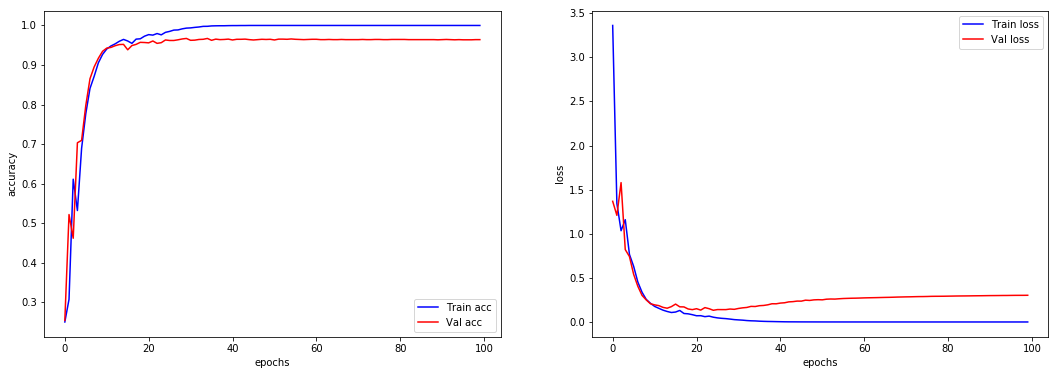

In [47]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## RNN 

In [53]:
def simple_rnn(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.SimpleRNN(32, input_shape=input_shape))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [54]:
X_train_RNN = np.array(X_train).reshape(X_train.shape[0],8,8)
X_val_RNN = np.array(X_val).reshape(X_val.shape[0],8,8)
X_test_RNN = np.array(X_test).reshape(X_test.shape[0],8,8)

In [55]:
rnn = simple_rnn(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 3,684
Trainable params: 3,684
Non-trainable params: 0
_________________________________________________________________


In [56]:
hist = rnn.fit(X_train_RNN, y_train_DL, epochs=300,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/300
7006/7006 [==============================] - 0s 61us/step - loss: 1.5357 - acc: 0.2351 - val_loss: 1.4664 - val_acc: 0.2693
Epoch 2/300
7006/7006 [==============================] - 0s 7us/step - loss: 1.4521 - acc: 0.2742 - val_loss: 1.3905 - val_acc: 0.3228
Epoch 3/300
7006/7006 [==============================] - 0s 7us/step - loss: 1.3799 - acc: 0.3283 - val_loss: 1.3280 - val_acc: 0.3763
Epoch 4/300
7006/7006 [==============================] - 0s 7us/step - loss: 1.3190 - acc: 0.3755 - val_loss: 1.2762 - val_acc: 0.4199
Epoch 5/300
7006/7006 [==============================] - 0s 8us/step - loss: 1.2669 - acc: 0.4262 - val_loss: 1.2317 - val_acc: 0.4649
Epoch 6/300
7006/7006 [==============================] - 0s 7us/step - loss: 1.2226 - acc: 0.4675 - val_loss: 1.1924 - val_acc: 0.4932
Epoch 7/300
7006/7006 [==============================] - 0s 7us/step - loss: 1.1830 - acc: 0.4941 - val_loss: 1.1577 - val_acc: 0.5094
Epoch 

7006/7006 [==============================] - 0s 7us/step - loss: 0.5439 - acc: 0.7953 - val_loss: 0.7158 - val_acc: 0.7235
Epoch 121/300
7006/7006 [==============================] - 0s 6us/step - loss: 0.5401 - acc: 0.7962 - val_loss: 0.7132 - val_acc: 0.7243
Epoch 122/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.5361 - acc: 0.7963 - val_loss: 0.7098 - val_acc: 0.7269
Epoch 123/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.5324 - acc: 0.7975 - val_loss: 0.7067 - val_acc: 0.7265
Epoch 124/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.5285 - acc: 0.7985 - val_loss: 0.7043 - val_acc: 0.7303
Epoch 125/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.5245 - acc: 0.8012 - val_loss: 0.7021 - val_acc: 0.7303
Epoch 126/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.5207 - acc: 0.8040 - val_loss: 0.6998 - val_acc: 0.7316
Epoch 127/300
7006/7006 [==============================

Epoch 180/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3611 - acc: 0.8717 - val_loss: 0.5963 - val_acc: 0.7885
Epoch 181/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3591 - acc: 0.8714 - val_loss: 0.5952 - val_acc: 0.7872
Epoch 182/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3566 - acc: 0.8723 - val_loss: 0.5958 - val_acc: 0.7851
Epoch 183/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3545 - acc: 0.8730 - val_loss: 0.5943 - val_acc: 0.7868
Epoch 184/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3527 - acc: 0.8743 - val_loss: 0.5922 - val_acc: 0.7872
Epoch 185/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3505 - acc: 0.8733 - val_loss: 0.5908 - val_acc: 0.7881
Epoch 186/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.3488 - acc: 0.8758 - val_loss: 0.5895 - val_acc: 0.7898
Epoch 187/300
7006/7006 [================

Epoch 240/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2761 - acc: 0.9052 - val_loss: 0.5738 - val_acc: 0.7971
Epoch 241/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2747 - acc: 0.9049 - val_loss: 0.5730 - val_acc: 0.7958
Epoch 242/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2738 - acc: 0.9057 - val_loss: 0.5748 - val_acc: 0.7979
Epoch 243/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2738 - acc: 0.9072 - val_loss: 0.5743 - val_acc: 0.7997
Epoch 244/300
7006/7006 [==============================] - 0s 9us/step - loss: 0.2728 - acc: 0.9078 - val_loss: 0.5707 - val_acc: 0.7988
Epoch 245/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2722 - acc: 0.9071 - val_loss: 0.5738 - val_acc: 0.7992
Epoch 246/300
7006/7006 [==============================] - 0s 7us/step - loss: 0.2714 - acc: 0.9058 - val_loss: 0.5735 - val_acc: 0.7975
Epoch 247/300
7006/7006 [================

Epoch 300/300
7006/7006 [==============================] - 0s 6us/step - loss: 0.2263 - acc: 0.9269 - val_loss: 0.5883 - val_acc: 0.7967


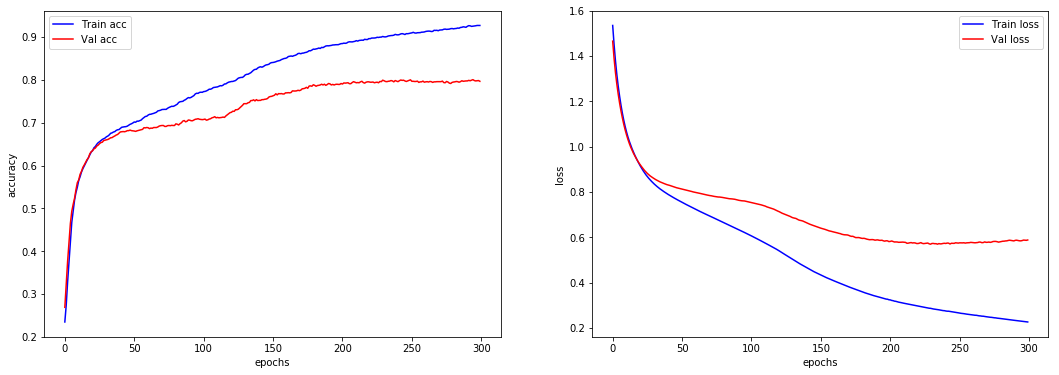

In [57]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [62]:
rnn = simple_rnn(input_shape=(8,8),n_classes=4)
hist = rnn.fit(X_train_RNN, y_train_DL, epochs=1000,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
Total params: 3,684
Trainable params: 3,684
Non-trainable params: 0
_________________________________________________________________
Train on 7006 samples, validate on 2336 samples
Epoch 1/1000
7006/7006 [==============================] - 0s 69us/step - loss: 1.4817 - acc: 0.2725 - val_loss: 1.4308 - val_acc: 0.2812
Epoch 2/1000
7006/7006 [==============================] - 0s 8us/step - loss: 1.4130 - acc: 0.2960 - val_loss: 1.3717 - val_acc: 0.3228
Epoch 3/1000
7006/7006 [==============================] - 0s 7us/step - loss: 1.355

Epoch 115/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.6078 - acc: 0.7688 - val_loss: 0.7708 - val_acc: 0.7063
Epoch 116/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.6053 - acc: 0.7705 - val_loss: 0.7700 - val_acc: 0.7072
Epoch 117/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.6031 - acc: 0.7718 - val_loss: 0.7688 - val_acc: 0.7076
Epoch 118/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.6010 - acc: 0.7728 - val_loss: 0.7680 - val_acc: 0.7068
Epoch 119/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.5987 - acc: 0.7738 - val_loss: 0.7667 - val_acc: 0.7072
Epoch 120/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.5964 - acc: 0.7755 - val_loss: 0.7649 - val_acc: 0.7072
Epoch 121/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.5942 - acc: 0.7758 - val_loss: 0.7630 - val_acc: 0.7089
Epoch 122/1000
7006/7006 [========

7006/7006 [==============================] - 0s 7us/step - loss: 0.3913 - acc: 0.8611 - val_loss: 0.6734 - val_acc: 0.7513
Epoch 234/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.3898 - acc: 0.8607 - val_loss: 0.6728 - val_acc: 0.7526
Epoch 235/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.3882 - acc: 0.8597 - val_loss: 0.6717 - val_acc: 0.7534
Epoch 236/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.3870 - acc: 0.8628 - val_loss: 0.6714 - val_acc: 0.7551
Epoch 237/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.3853 - acc: 0.8630 - val_loss: 0.6708 - val_acc: 0.7560
Epoch 238/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.3836 - acc: 0.8643 - val_loss: 0.6703 - val_acc: 0.7564
Epoch 239/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.3821 - acc: 0.8653 - val_loss: 0.6698 - val_acc: 0.7547
Epoch 240/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 8us/step - loss: 0.2527 - acc: 0.9141 - val_loss: 0.6970 - val_acc: 0.7740
Epoch 352/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.2518 - acc: 0.9142 - val_loss: 0.6980 - val_acc: 0.7718
Epoch 353/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.2511 - acc: 0.9155 - val_loss: 0.6996 - val_acc: 0.7684
Epoch 354/1000
7006/7006 [==============================] - 0s 8us/step - loss: 0.2502 - acc: 0.9145 - val_loss: 0.7006 - val_acc: 0.7705
Epoch 355/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.2496 - acc: 0.9148 - val_loss: 0.7024 - val_acc: 0.7684
Epoch 356/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.2488 - acc: 0.9158 - val_loss: 0.7030 - val_acc: 0.7684
Epoch 357/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.2482 - acc: 0.9168 - val_loss: 0.7040 - val_acc: 0.7684
Epoch 358/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 7us/step - loss: 0.1775 - acc: 0.9479 - val_loss: 0.8001 - val_acc: 0.7718
Epoch 470/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1766 - acc: 0.9475 - val_loss: 0.8010 - val_acc: 0.7693
Epoch 471/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1766 - acc: 0.9479 - val_loss: 0.8015 - val_acc: 0.7710
Epoch 472/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1760 - acc: 0.9480 - val_loss: 0.8044 - val_acc: 0.7693
Epoch 473/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1754 - acc: 0.9479 - val_loss: 0.8066 - val_acc: 0.7688
Epoch 474/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1751 - acc: 0.9473 - val_loss: 0.8072 - val_acc: 0.7693
Epoch 475/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1743 - acc: 0.9485 - val_loss: 0.8065 - val_acc: 0.7714
Epoch 476/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 6us/step - loss: 0.1277 - acc: 0.9680 - val_loss: 0.9248 - val_acc: 0.7710
Epoch 588/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1272 - acc: 0.9673 - val_loss: 0.9233 - val_acc: 0.7705
Epoch 589/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1270 - acc: 0.9672 - val_loss: 0.9234 - val_acc: 0.7701
Epoch 590/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1266 - acc: 0.9673 - val_loss: 0.9249 - val_acc: 0.7697
Epoch 591/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1263 - acc: 0.9667 - val_loss: 0.9267 - val_acc: 0.7697
Epoch 592/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1258 - acc: 0.9673 - val_loss: 0.9279 - val_acc: 0.7701
Epoch 593/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.1255 - acc: 0.9672 - val_loss: 0.9290 - val_acc: 0.7671
Epoch 594/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 7us/step - loss: 0.0937 - acc: 0.9803 - val_loss: 1.0549 - val_acc: 0.7611
Epoch 706/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.0931 - acc: 0.9802 - val_loss: 1.0566 - val_acc: 0.7594
Epoch 707/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.0930 - acc: 0.9810 - val_loss: 1.0547 - val_acc: 0.7620
Epoch 708/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.0927 - acc: 0.9809 - val_loss: 1.0548 - val_acc: 0.7611
Epoch 709/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0926 - acc: 0.9816 - val_loss: 1.0583 - val_acc: 0.7607
Epoch 710/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0921 - acc: 0.9814 - val_loss: 1.0603 - val_acc: 0.7603
Epoch 711/1000
7006/7006 [==============================] - 0s 6us/step - loss: 0.0921 - acc: 0.9812 - val_loss: 1.0625 - val_acc: 0.7616
Epoch 712/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 7us/step - loss: 0.0688 - acc: 0.9896 - val_loss: 1.1986 - val_acc: 0.7586
Epoch 824/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0685 - acc: 0.9902 - val_loss: 1.1977 - val_acc: 0.7581
Epoch 825/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0683 - acc: 0.9907 - val_loss: 1.2011 - val_acc: 0.7594
Epoch 826/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0682 - acc: 0.9906 - val_loss: 1.2065 - val_acc: 0.7568
Epoch 827/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0682 - acc: 0.9902 - val_loss: 1.2053 - val_acc: 0.7586
Epoch 828/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0679 - acc: 0.9902 - val_loss: 1.2026 - val_acc: 0.7603
Epoch 829/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0676 - acc: 0.9904 - val_loss: 1.2078 - val_acc: 0.7564
Epoch 830/1000
7006/7006 [=======================

7006/7006 [==============================] - 0s 7us/step - loss: 0.0492 - acc: 0.9949 - val_loss: 1.3497 - val_acc: 0.7560
Epoch 942/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0491 - acc: 0.9953 - val_loss: 1.3517 - val_acc: 0.7551
Epoch 943/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0491 - acc: 0.9946 - val_loss: 1.3537 - val_acc: 0.7547
Epoch 944/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0490 - acc: 0.9947 - val_loss: 1.3582 - val_acc: 0.7539
Epoch 945/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0489 - acc: 0.9949 - val_loss: 1.3577 - val_acc: 0.7530
Epoch 946/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0486 - acc: 0.9947 - val_loss: 1.3548 - val_acc: 0.7547
Epoch 947/1000
7006/7006 [==============================] - 0s 7us/step - loss: 0.0487 - acc: 0.9946 - val_loss: 1.3605 - val_acc: 0.7543
Epoch 948/1000
7006/7006 [=======================

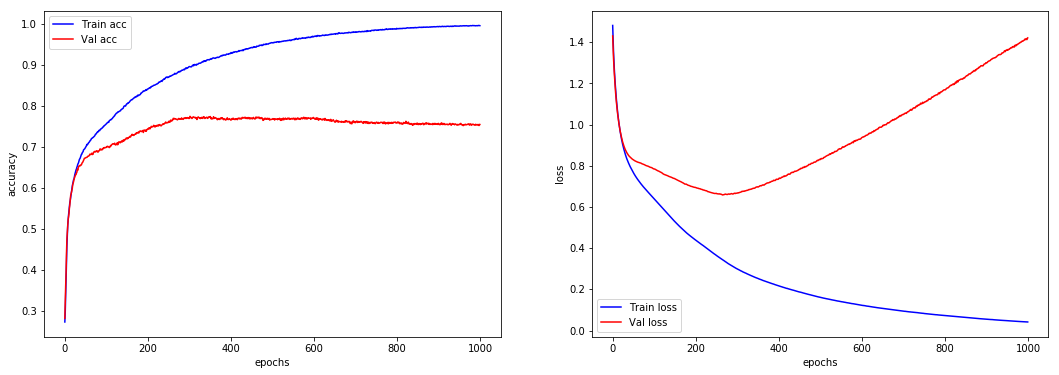

In [63]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## LSTM 

In [64]:
def LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.LSTM(32, input_shape=input_shape,return_sequences=True))
    model.add(layers.LSTM(64,return_sequences=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [65]:
lstm = LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 32)             5248      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 64)             24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 516       
Total params: 145,924
Trainable params: 145,924
Non-trainable params: 0
_________________________________________________________________


In [66]:
hist = lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 2s 287us/step - loss: 1.3712 - acc: 0.3967 - val_loss: 1.3299 - val_acc: 0.5839
Epoch 2/100
7006/7006 [==============================] - 0s 31us/step - loss: 1.3040 - acc: 0.5961 - val_loss: 1.2340 - val_acc: 0.6100
Epoch 3/100
7006/7006 [==============================] - 0s 31us/step - loss: 1.1839 - acc: 0.6021 - val_loss: 1.0616 - val_acc: 0.6019
Epoch 4/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.9883 - acc: 0.6118 - val_loss: 0.8443 - val_acc: 0.6533
Epoch 5/100
7006/7006 [==============================] - 0s 29us/step - loss: 0.7779 - acc: 0.6810 - val_loss: 0.6871 - val_acc: 0.7175
Epoch 6/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.6264 - acc: 0.7436 - val_loss: 0.5643 - val_acc: 0.8022
Epoch 7/100
7006/7006 [==============================] - 0s 30us/step - loss: 0.5169 - acc: 0.8212 - val_loss: 0.4943 - val_acc: 0.8193

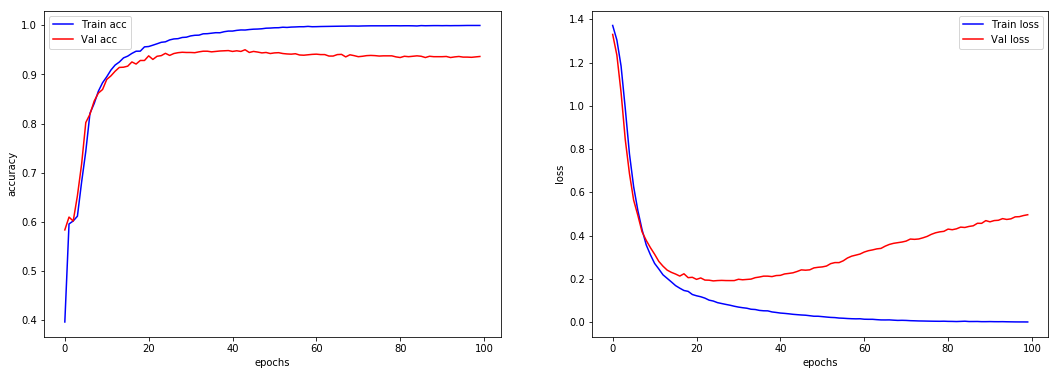

In [67]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## CNN-LSTM 

In [68]:
def CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv1D(64,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(128,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.Conv1D(256,3,activation='relu',padding='same'))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128, return_sequences = True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [69]:
cnn_lstm = CNN_LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 32)             800       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 128)            24704     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 8, 256)            98560     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 256)            196864    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 128)            131584    
__________

In [70]:
hist = cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=100,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/100
7006/7006 [==============================] - 3s 493us/step - loss: 1.3765 - acc: 0.2916 - val_loss: 1.3111 - val_acc: 0.3703
Epoch 2/100
7006/7006 [==============================] - 0s 54us/step - loss: 1.3094 - acc: 0.3989 - val_loss: 1.2688 - val_acc: 0.3690
Epoch 3/100
7006/7006 [==============================] - 0s 51us/step - loss: 1.1760 - acc: 0.4488 - val_loss: 0.9651 - val_acc: 0.6066
Epoch 4/100
7006/7006 [==============================] - 0s 51us/step - loss: 0.9429 - acc: 0.6082 - val_loss: 0.8217 - val_acc: 0.6605
Epoch 5/100
7006/7006 [==============================] - 0s 51us/step - loss: 0.7534 - acc: 0.6701 - val_loss: 0.7217 - val_acc: 0.6725
Epoch 6/100
7006/7006 [==============================] - 0s 50us/step - loss: 0.6476 - acc: 0.7108 - val_loss: 0.6063 - val_acc: 0.7342
Epoch 7/100
7006/7006 [==============================] - 0s 52us/step - loss: 0.5474 - acc: 0.7566 - val_loss: 0.5114 - val_acc: 0.7924

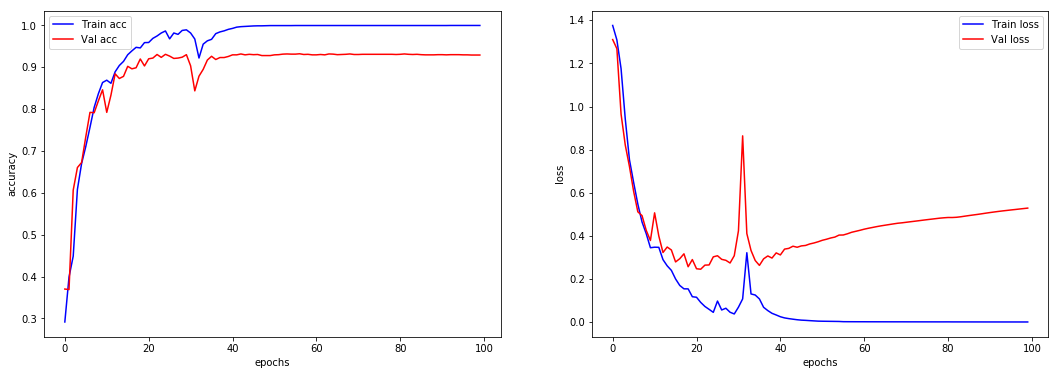

In [71]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## Shallow CNN-LSTM 

In [73]:
def shallow_CNN_LSTM(input_shape, n_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(32,3,activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.LSTM(64))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

In [74]:
shallow_cnn_lstm = shallow_CNN_LSTM(input_shape=(8,8),n_classes=4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 32)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 516       
Total params: 34,468
Trainable params: 34,468
Non-trainable params: 0
_________________________________________________________________


In [75]:
hist = shallow_cnn_lstm.fit(X_train_RNN, y_train_DL, epochs=300,batch_size=2048,validation_data=(X_val_RNN,y_val_DL))

Train on 7006 samples, validate on 2336 samples
Epoch 1/300
7006/7006 [==============================] - 1s 200us/step - loss: 1.4236 - acc: 0.2561 - val_loss: 1.3361 - val_acc: 0.3677
Epoch 2/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.3006 - acc: 0.4312 - val_loss: 1.2311 - val_acc: 0.5227
Epoch 3/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.1915 - acc: 0.5669 - val_loss: 1.1125 - val_acc: 0.6276
Epoch 4/300
7006/7006 [==============================] - 0s 13us/step - loss: 1.0666 - acc: 0.6537 - val_loss: 0.9751 - val_acc: 0.6725
Epoch 5/300
7006/7006 [==============================] - 0s 13us/step - loss: 0.9228 - acc: 0.7038 - val_loss: 0.8353 - val_acc: 0.7175
Epoch 6/300
7006/7006 [==============================] - 0s 13us/step - loss: 0.7802 - acc: 0.7445 - val_loss: 0.7025 - val_acc: 0.7620
Epoch 7/300
7006/7006 [==============================] - 0s 13us/step - loss: 0.6473 - acc: 0.7826 - val_loss: 0.5871 - val_acc: 0.7975

Epoch 119/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.8218e-04 - acc: 1.0000 - val_loss: 0.2820 - val_acc: 0.9478
Epoch 120/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.7203e-04 - acc: 1.0000 - val_loss: 0.2828 - val_acc: 0.9473
Epoch 121/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.6195e-04 - acc: 1.0000 - val_loss: 0.2833 - val_acc: 0.9478
Epoch 122/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.5150e-04 - acc: 1.0000 - val_loss: 0.2837 - val_acc: 0.9482
Epoch 123/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.4391e-04 - acc: 1.0000 - val_loss: 0.2841 - val_acc: 0.9478
Epoch 124/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.3510e-04 - acc: 1.0000 - val_loss: 0.2849 - val_acc: 0.9473
Epoch 125/300
7006/7006 [==============================] - 0s 13us/step - loss: 4.2549e-04 - acc: 1.0000 - val_loss: 0.2858 - val_acc: 0.9478
Epoch 

Epoch 234/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.6641e-05 - acc: 1.0000 - val_loss: 0.3265 - val_acc: 0.9482
Epoch 235/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.5711e-05 - acc: 1.0000 - val_loss: 0.3269 - val_acc: 0.9482
Epoch 236/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.4821e-05 - acc: 1.0000 - val_loss: 0.3271 - val_acc: 0.9482
Epoch 237/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.3935e-05 - acc: 1.0000 - val_loss: 0.3274 - val_acc: 0.9482
Epoch 238/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.3029e-05 - acc: 1.0000 - val_loss: 0.3276 - val_acc: 0.9482
Epoch 239/300
7006/7006 [==============================] - 0s 13us/step - loss: 9.2151e-05 - acc: 1.0000 - val_loss: 0.3279 - val_acc: 0.9478
Epoch 240/300
7006/7006 [==============================] - 0s 12us/step - loss: 9.1311e-05 - acc: 1.0000 - val_loss: 0.3281 - val_acc: 0.9478
Epoch 

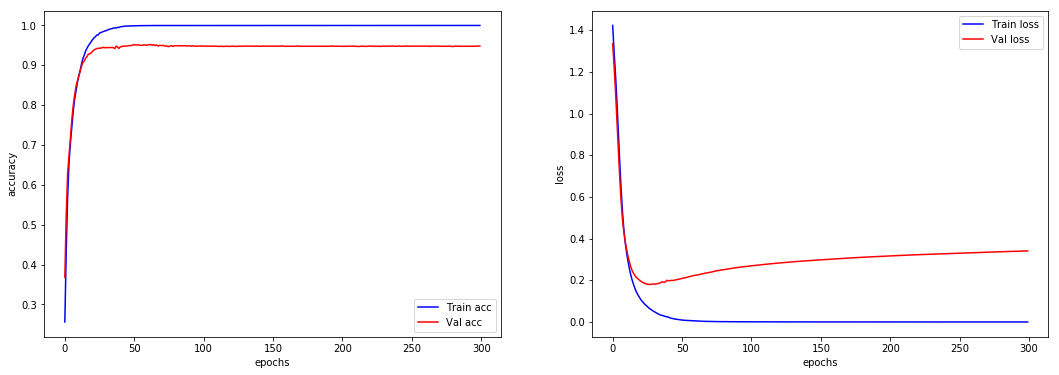

In [76]:
plt.figure(figsize=(18,6))
plt.subplot(121)
line1, = plt.plot(hist.history['acc'], 'b', label='Train acc')
line2, = plt.plot(hist.history['val_acc'], 'r', label='Val acc')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.subplot(122)
line1, = plt.plot(hist.history['loss'], 'b', label='Train loss')
line2, = plt.plot(hist.history['val_loss'], 'r', label='Val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

## test set을 활용한 최종 결과 evaluation 

## 결론